[*********************100%***********************]  1 of 1 completed
c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Loss: 0.278031, LR: 0.001000
Epoch 2/100, Loss: 0.023695, LR: 0.001000
Epoch 3/100, Loss: 0.019582, LR: 0.001000
Epoch 4/100, Loss: 0.014596, LR: 0.001000
Epoch 5/100, Loss: 0.011531, LR: 0.001000
Epoch 6/100, Loss: 0.007390, LR: 0.001000
Epoch 7/100, Loss: 0.007102, LR: 0.001000
Epoch 8/100, Loss: 0.005705, LR: 0.001000
Epoch 9/100, Loss: 0.004671, LR: 0.001000
Epoch 10/100, Loss: 0.003970, LR: 0.001000
Epoch 11/100, Loss: 0.003594, LR: 0.001000
Epoch 12/100, Loss: 0.003589, LR: 0.001000
Epoch 13/100, Loss: 0.003288, LR: 0.001000
Epoch 14/100, Loss: 0.003663, LR: 0.001000
Epoch 15/100, Loss: 0.003156, LR: 0.001000
Epoch 16/100, Loss: 0.002916, LR: 0.001000
Epoch 17/100, Loss: 0.003008, LR: 0.001000
Epoch 18/100, Loss: 0.003170, LR: 0.001000
Epoch 19/100, Loss: 0.002965, LR: 0.001000
Epoch 20/100, Loss: 0.002977, LR: 0.000500
Epoch 21/100, Loss: 0.002751, LR: 0.000500
Epoch 22/100, Loss: 0.002535, LR: 0.000500
Epoch 23/100, Loss: 0.002504, LR: 0.000500
Epoch 24/100, Loss: 

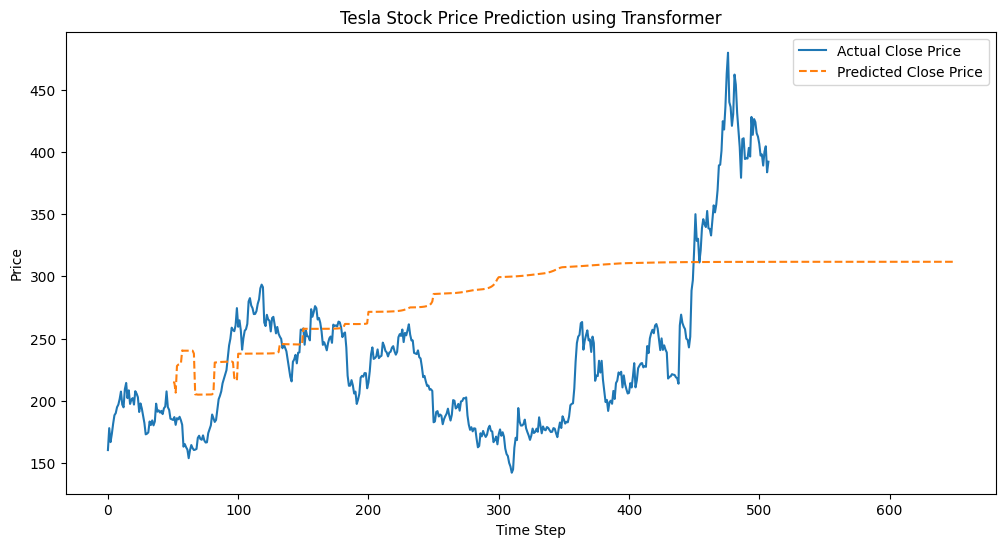

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 로딩 및 전처리
def load_and_preprocess_data(ticker, start_date, end_date, features=['Close', 'Volume', 'Open', 'High', 'Low'], split_ratio=0.8):
    """
    yfinance를 사용하여 주가 데이터를 다운로드하고, 지정한 features를 선택 후 정규화 및 학습/테스트 분할을 수행합니다.

    data : 데이터프레임 df에서 features에 해당하는 열들을 선택한 후, numpy array로 변환한 값. 즉 2차원 크기의 넘파이 배열임
        [
          [120.15, 30000000, 119.50, 121.00, 119.10],
          [121.45, 35000000, 120.80, 122.50, 120.50],
          [119.90, 40000000, 120.00, 121.50, 118.80],
        ]
    """
    df = yf.download(ticker, start=start_date, end=end_date)
    data = df[features].values  # shape: [num_samples, num_features]

    # data 확인
    print(f"Data Sample: {data[:5]}")
    # size 확인 
    print(f"Data Shape: {data.shape}")

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data) # -> 각 feature 별로 0~1 사이의 값으로 정규화
    split_idx = int(len(data_scaled) * split_ratio)
    train_data = data_scaled[:split_idx]
    test_data = data_scaled[split_idx:]

    # train_data, test_data 확인
    print(f"Train Data Shape: {train_data.shape}")
    print(f"Test Data Shape: {test_data.shape}")

    return train_data, test_data, scaler

# 2. Dataset 및 DataLoader 구성
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length
    
    # 유효 샘플 개수 반환
    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        src = self.data[idx:idx + self.seq_length]  # [seq_length, num_features]
        tgt = self.data[idx + self.seq_length]       # [num_features]
        return src, tgt

def create_dataloader(data, seq_length, batch_size, shuffle=True):
    dataset = TimeSeriesDataset(data, seq_length)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

# 3. Transformer 기반 시계열 예측 모델 정의
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout
        )
        self.fc_out = nn.Linear(d_model, input_dim)

    def forward(self, src, tgt):
        # src: [S, N, input_dim], tgt: [T, N, input_dim]
        src_emb = self.embedding(src)   # [S, N, d_model]
        tgt_emb = self.embedding(tgt)     # [T, N, d_model]
        output = self.transformer(src_emb, tgt_emb)  # [T, N, d_model]
        return self.fc_out(output)      # [T, N, input_dim]

# 4. 모델 학습 함수 (스케쥴러 추가)
def train_model(model, train_loader, device, epochs, learning_rate=0.001):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.5)  # 20 에폭마다 lr 0.5배 감소
    
    for epoch in range(epochs):
        epoch_loss = 0
        for src, tgt in train_loader:
            src = src.to(device)   # [batch, seq_length, input_dim]
            tgt = tgt.to(device)   # [batch, input_dim]
            
            # Transformer 입력은 [sequence_length, batch, feature]
            src = src.transpose(0, 1)  # [seq_length, batch, input_dim]
            # 디코더 입력: 단일 스텝 예측을 위해 0 벡터 사용 (shape: [1, batch, input_dim])
            tgt_decoder = torch.zeros(1, src.size(1), src.size(2)).to(device)
            
            optimizer.zero_grad()
            output = model(src, tgt_decoder)  # [1, batch, input_dim]
            output = output.squeeze(0)         # [batch, input_dim]
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()  # 스케쥴러 업데이트
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}, LR: {current_lr:.6f}")

# 5. 미래 주가 예측 (rollout 방식)
def predict_future(model, test_data, seq_length, num_prediction, device):
    model.eval()
    test_input = torch.tensor(test_data[:seq_length], dtype=torch.float32).to(device)  # [seq_length, input_dim]
    predictions = []
    with torch.no_grad():
        for _ in range(num_prediction):
            src = test_input.unsqueeze(1)  # [seq_length, 1, input_dim]
            tgt_decoder = torch.zeros(1, 1, test_input.size(-1)).to(device)
            out = model(src, tgt_decoder)    # out shape: [1, 1, input_dim]
            # 두 차원만 squeeze해서 [input_dim] 형태로 변경
            pred = out.squeeze(0).squeeze(0)   # [input_dim]
            predictions.append(pred.cpu().numpy())  # 5개 피처 예측값 저장
            # 시퀀스 업데이트: 가장 오래된 값 제거 후 예측값 추가
            test_input = torch.cat([test_input[1:], pred.unsqueeze(0)], dim=0) # [seq_length, input_dim]
    return np.array(predictions)  # shape: [num_prediction, input_dim]

# 6. 결과 시각화 함수 (Close price만 시각화)
def plot_predictions(actual, predictions, seq_length):
    plt.figure(figsize=(12,6))
    # actual: [num_samples, num_features], predictions: [num_prediction, num_features]
    plt.plot(actual[:, 0], label="Actual Close Price")
    plt.plot(range(seq_length, seq_length + len(predictions)), predictions[:, 0], 
             label="Predicted Close Price", linestyle="dashed")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.title("Tesla Stock Price Prediction using Transformer")
    plt.legend()
    plt.show()

# 7. 메인 실행 함수
def main():
    # 설정값
    ticker = "TSLA"
    start_date = "2015-01-01"
    end_date = "2025-02-05"
    seq_length = 50       # 입력 시퀀스 길이 (예: 50일)
    batch_size = 32
    epochs = 100
    num_prediction = 600   # 예측할 미래 시점 개수
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 데이터 로딩 및 전처리 (5개의 피처 사용)
    train_data, test_data, scaler = load_and_preprocess_data(
        ticker, start_date, end_date, features=['Close', 'Volume', 'Open', 'High', 'Low'], split_ratio=0.8
    )
    
    # DataLoader 생성
    train_loader = create_dataloader(train_data, seq_length, batch_size)
    
    # 모델 생성 (입력 차원 수정: 5개의 피처)
    model = TimeSeriesTransformer(input_dim=5, d_model=252, nhead=4, num_layers=3).to(device)
    
    # 모델 학습 (스케쥴러 포함)
    train_model(model, train_loader, device, epochs, learning_rate=0.001)
    
    # 미래 주가 예측
    predictions = predict_future(model, test_data, seq_length, num_prediction, device)  # shape: [num_prediction, input_dim]
    # 역정규화: 모든 피처 역정규화 (시각화는 Close 피처만 사용)
    predictions_inverse = scaler.inverse_transform(predictions)
    actual_test = scaler.inverse_transform(test_data)
    
    # 결과 시각화 (Close price만)
    plot_predictions(actual_test, predictions_inverse, seq_length)

if __name__ == "__main__":
    main()
